In [1]:
%matplotlib inline
import numpy as np, pickle, threading, pyaudio, cv2, time, matplotlib.pyplot as plt, math
from IPython.display import clear_output

In [2]:
def takePhoto(adaptTime=2):
    cap = cv2.VideoCapture(0)
    # 初始化摄像头，摄像头适应光源
    for _ in range(adaptTime):
        cap.read()
    ret, frame = cap.read()
    if not ret:
        print('camera not working')
    cap.release()
    print('Image shape: ', frame.shape)
    return frame

In [8]:
img = takePhoto()
data = img[200:210, 300:310, 2]
print(data)

Image shape:  (480, 640, 3)
[[158 158 158 158 160 160 160 160 160 160]
 [158 158 158 158 160 160 160 160 160 160]
 [158 158 158 158 160 160 160 160 160 160]
 [158 158 158 158 160 160 160 160 160 160]
 [158 158 158 158 160 160 160 160 160 160]
 [158 158 158 158 160 160 160 160 160 160]
 [158 158 158 158 160 160 160 160 160 160]
 [158 158 158 158 160 160 160 160 160 160]
 [160 160 160 160 156 159 161 160 158 157]
 [159 159 159 159 162 162 161 159 156 153]]


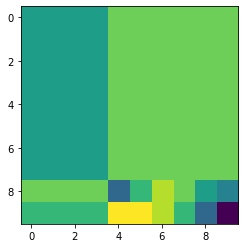

In [10]:
plt.imshow(data)
plt.show()

In [5]:
class NeuronCell(object):
    def __init__(self, ID, hiddenLayer):
        self.id = ID
        # hidden layers number and each layer nodes number
        self.hl = hiddenLayer
        self.layerNum = len(self.hl) + 2
        self.lr = 0.01
        # ID: Index
        self.neuronMap = {
            'in':dict(), 
            'out':dict()
        }
        self.outputs = None
        self.data = [None] * (self.layerNum)
        self.weights = [None] * (self.layerNum - 1)
        self.bias = [None] * (self.layerNum - 1)
        self.connWeights = np.ones(0, dtype=float)
        self.paramLimit = {
            'data': (-10000, 10000), 
            'weight': (-100, 100), 
            'bias': (-100, 100), 
            'connWeight': (0, 1)
        }
        
    def initParams(self):
        nodes = (0, *self.hl, 0)
        for i in range(self.layerNum-1):
            self.data[i] = np.zeros(nodes[i], dtype=float)
            self.bias[i] = np.zeros(nodes[i], dtype=float)
            self.weights[i] = np.ones((nodes[i], nodes[i+1]), dtype=float)
        self.data[-1] = np.zeros(nodes[-1], dtype=float)
        return True
    
    def zeroInput(self):
        self.data[0] = np.zeros_like(self.data[0])

    def addInput(self, neuronID):
        if neuronID not in self.neuronMap['in'].keys():
            self.data[0] = np.append(self.data[0], 0)
            self.neuronMap['in'][neuronID] = len(self.data[0]) - 1
#             print(f'ID {self.id} Weights[0]: {self.weights[0]}')
            self.weights[0] = np.append(self.weights[0], np.ones((1, self.hl[0]), dtype=float), axis=0)
            return True
        else:
            print(f'Neuron {self.id} already has ID:{neuronID} at port: IN')
            return False
    
    def addOutput(self, neuronID):
        if neuronID not in self.neuronMap['out'].keys():
            self.data[-1] = np.append(self.data[-1], 0)
            self.neuronMap['out'][neuronID] = len(self.data[-1]) - 1
#             print(f'ID {self.id} Weights[-1]: {self.weights[-1]}')
            self.weights[-1] = np.append(self.weights[-1], np.ones((self.hl[0], 1), dtype=float), axis=1)
            self.connWeights = np.append(self.connWeights, 1)
            return True
        else:
            print(f'Neuron {self.id} already has ID:{neuronID} at port: OUT')
            return False
    
    def deleteInput(self, neuronID):
        try:
            index = self.neuronMap['in'][neuronID]
        except:
            print(f'Neuron id: {neuronID} not found in port: IN')
            return false
        self.data[0] = np.delete(self.data[0], index)
        del self.neuronMap['in'][neuronID]
        self.weights[0] = np.delete(self.weights[0], index, axis=0)
    
    def deleteOutput(self, neuronID):
        try:
            index = self.neuronMap['out'][neuronID]
        except:
            print(f'Neuron id: {neuronID} not found in port: OUT')
            return false
        self.data[-1] = np.delete(self.data[-1], index)
        del self.neuronMap['out'][neuronID]
        self.weights[-1] = np.delete(self.weights[-1], index, axis=1)
        self.connWeights = np.delete(self.connWeights, index)
            
    def inputData(self, neuronID, data):
        index = self.neuronMap['in'][neuronID]
        self.data[0][index] = data
        return True
    
    def forward(self):
        self.setToLimit(self.data[0], 'data')
        for i in range(1, len(self.data)-1):
            self.data[i] = self.data[i-1] @ self.weights[i-1] + self.bias[i-1]
            self.setToLimit(self.data[i], 'data')
            self.data[i] = self.leakyRelu(self.data[i])
        self.data[-1] = self.data[-2] @ self.weights[-1] + self.bias[-1]
        self.setToLimit(self.data[-1], 'data')
        self.outputs = self.data[-1] * self.connWeights
        return self.outputs
    
    def updateParams(self, feedback):
        dConnWeights = self.connWeights * feedback * self.lr
        self.connWeights += dConnWeights
        self.setToLimit(self.connWeights, 'connWeight')
        for i in range(self.layerNum-1):
            self.bias[i] += self.signOfData(self.bias[i]) * feedback * self.lr
            self.weights[i] += self.signOfData(self.weights[i]) * feedback * self.lr
            self.setToLimit(self.bias[i], 'bias')
            self.setToLimit(self.weights, 'weight')
    
    def setToLimit(self, params, paramName):
        minimum = self.paramLimit[paramName][0]
        maximum = self.paramLimit[paramName][1]
        params[params<minimum] = minimum
        params[params==-np.inf] = minimum
        params[params>maximum] = maximum
        params[params==np.inf] = maximum
    
    def leakyRelu(self, x):
        return np.maximum(x, x*p)
    
    def leakyReluDer(self, x): # 用处不大
        data = np.copy(x)
        data[data>0] = 1
        data[data<=0] = 0.01
        return data
    
    def signOfData(self, x):
        data = np.copy(x)
        data[data<0] = -1
        data[data>0] = 1
        return data

    def getParams(self):
        params = {
            'data': self.data, 
            'outputs': self.outputs, 
            'weights': self.weights, 
            'bias': self.bias, 
            'connWeights': self.connWeights, 
            'limits': self.paramLimit, 
            'neuron map': self.neuronMap
        }
        return params

In [6]:
class Brain(object):
    def __init__(self):
        # 神经元数量
        self.neuronNum = 0
        # 所有神经元, id: neuron
        self.absoluteID = {}
        # 分区
        self.sections = {
            'input': [], 
            'think': [], 
            'output': []
        }
        # 准备发射神经元ID(梯队)
        self.readyNeurons = {
            0: set(), 
            1: set()
        }
        
    # 增加神经元
    def addNeuron(self, number, hiddenLayer, idPrefix, startIndex=0, section=None):
        self.neuronNum += number
        for i in range(startIndex, startIndex+number):
            ID = idPrefix+'_'+str(i)
            self.absoluteID[ID] = NeuronCell(ID, hiddenLayer)
            self.absoluteID[ID].initParams()
            if section != None:
                self.sections[section].append(ID)
        self.sections[section] = list(set(self.sections[section]))
        return True
    
    def addConn(self, idToAdd, idAddTo, port):
        if port == 'in':
            self.absoluteID[idAddTo].addInput(idToAdd)
        elif port == 'out':
            self.absoluteID[idAddTo].addOutput(idToAdd)
        else:
            print('No such port: ', port, 'only in or out')
        return True
        
    def conn2Neurons(self, idFrom, idTo):
        neuronFrom = self.absoluteID[idFrom]
        neuronTo = self.absoluteID[idTo]
        neuronFrom.addOutput(idTo)
        neuronTo.addInput(idFrom)
        return True
    
    def oneWayConn2Group(self, groupIdFrom, groupIdTo, selfConn):
        for idFrom in groupIdFrom:
            for idTo in groupIdTo:
                if idFrom == idTo and not selfConn:
                    continue
                self.conn2Neurons(idFrom, idTo)
        return True
    
    def sendData(self, idFrom, data):
        neuronFrom = self.absoluteID[idFrom]
        idTos = neuronFrom.neuronMap['out']
        for idTo, index in idTos.items():
            self.absoluteID[idTo].inputData(idFrom, data[index])
        return True
    
    def setReadyNeurons(self, neuronIDs):
        self.readyNeurons[0] = self.readyNeurons[0].union(neuronIDs)
        
    def groupInput(self, groupId, data):
        for i in range(len(groupId)):
            inputID = 'input_'+str(i)
            self.absoluteID[groupId[i]].inputData(inputID, data[i])
        return True
    
    def think(self):
        self.readyNeurons[1] = set()
        for ID in self.readyNeurons[0]:
            self.absoluteID[ID].forward()
            self.readyNeurons[1] = self.readyNeurons[1].union(self.absoluteID[ID].neuronMap['out'].keys())
        self.readyNeurons[0] = self.readyNeurons[1]
        return True
    
    def giveOutput(self, groupId):
        temp = np.empty(0, dtype=float)
        for ID in groupId:
            temp = np.append(temp, self.absoluteID[ID].outputs)
        return temp
    
    def updateNeurons(self, groupId, feedback):
        for ID in groupId:
            self.absoluteID[ID].updateParams(feedback)
    
    def tanh(self, x):
        return np.tanh(x)

In [ ]:
In_hlParam = (10, 10)
Think_hlParam = (100, 100)
Out_hlParam = (10, 10)
b01 = Brain()
t = time.time()
b01.addNeuron(100, In_hlParam, 'I', 0, 'input')
b01.addNeuron(1000, Think_hlParam, 'T', 0, 'think')
b01.addNeuron(100, Out_hlParam, 'O', 0, 'output')
print('add neuron used time: ', time.time()-t)

t = time.time()
b01.oneWayConn2Group(b01.sections['input'], b01.sections['think'][0:100], False)
b01.oneWayConn2Group(b01.sections['think'], b01.sections['think'], False)
b01.oneWayConn2Group(b01.sections['think'][-100:-1], b01.sections['output'], False)
for i in range(100):
    b01.addConn('input_'+str(i), b01.sections['input'][i], 'in')
    b01.addConn('output_'+str(i), b01.sections['output'][i], 'out')
print('connect neuron used time: ', time.time()-t)

t = time.time()
b01.groupInput(b01.sections['input'], data)
print('input data used time: ', time.time()-t)
print('Done')

add neuron used time:  0.07693600654602051
